In [1]:
# This is file for train, prediction

import pandas as pd

dirpath = "C:/Users/rihot/Desktop/Deep_learning/DACON_used_car_price/"

train = pd.read_csv('data/preprocessed_train.csv')
test = pd.read_csv('data/preprocessed_test.csv')

In [2]:
train.head()

,title,odometer,location,isimported,engine,transmission,fuel,paint,year,brand,target
0,152,18277,0,0,0,0,0,1,2016,38,13665000
1,97,10,0,2,0,0,0,7,2019,38,33015000
2,137,83091,0,0,3,0,0,1,2012,5,9915000
3,226,91524,0,0,0,0,0,16,2007,30,3815000
4,60,94177,0,0,3,0,0,1,2010,38,7385000


In [3]:
test.head()

,title,odometer,location,isimported,engine,transmission,fuel,paint,year,brand
0,113,1234,1,2,0,0,0,2,2017,6
1,194,29938,1,0,0,0,0,2,2013,25
2,213,87501,0,0,0,0,0,7,2012,6
3,230,180894,0,1,3,0,0,16,2001,38
4,18,104814,0,0,0,0,0,2,2000,38


In [4]:
Y = train[ ['target'] ].values
X = train[ [ 'title', 'odometer', 'isimported', 'engine', 'paint', 'year', 'brand' ] ].values
# X = train[ ['title', 'odometer', 'location', 'isimported', 'engine', 'transmission', 'fuel', 'paint', 'year', 'brand' ] ].values

In [5]:
X.shape, Y.shape

((1015, 7), (1015, 1))

In [6]:
import numpy as np

X1 = train[['odometer']].values
X2 = train[['title','isimported','engine','paint','year','brand']].values

Y = np.log(Y)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scalerX1 = MinMaxScaler()
scalerX1.fit(X1)
X1 = scalerX1.transform(X1)

scalerX2 = StandardScaler()
scalerX2.fit(X2)
X2 = scalerX2.transform(X2)

X = np.concatenate([X1,X2], axis=1)

scalerY = MinMaxScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

In [8]:
X.shape, Y.shape

((1015, 7), (1015, 1))

In [9]:
CFG = {
    'EPOCHS':1500,
    'BATCH_SIZE':32,
    'LEARNING_RATE' :3e-4
}

In [10]:
from torch import nn

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(7, 64, bias=False),
            nn.BatchNorm1d(64, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Linear(64, 128, bias=False),
            nn.BatchNorm1d(128, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(128, 256, bias=False),
            nn.BatchNorm1d(256, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Linear(256, 256, bias=False),
            nn.BatchNorm1d(256, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Linear(256, 128, bias=False),
            nn.BatchNorm1d(128, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64, eps=1e-05, momentum=0.1),
            nn.ReLU()
        )

        self.layer7 = nn.Linear(64, 1, bias=False)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)

        return x

In [11]:
import torch

loss_ = [] # loss 저장할 리스트
val_loss_ = [] # val loss 저장할 리스트
best_loss_ = []

def train(model, optimizer, trainloader, valloader):
    best_loss = 1000 # to save best model
    criterion = nn.MSELoss()

    for epoch in range(1, CFG["EPOCHS"]+1):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, values = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, values)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # print('[%d] Train loss: %.10f' %(epoch, running_loss))
        loss_.append(running_loss)

        #validation set evaluation
        model.eval()
        val_loss = 0.0

        predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
        actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for i, data in enumerate(valloader, 0): # enumerate(인자, index)
                inputs, values = data
                outputs = model(inputs)
                loss = criterion(outputs, values)

                val_loss += loss.item()

        # print('[%d] Validation loss: %.10f' %(epoch, val_loss))

        if val_loss < best_loss :
            torch.save(model.state_dict(), dirpath + "best_model/" + "_best_model.pth")
            best_loss = val_loss
            print('model saved')
            print('[%d] Validation loss: %.10f' %(epoch, val_loss))

        if epoch == 150:
            best_loss_.append(best_loss)

        val_loss_.append(val_loss)

In [12]:
from torch.utils.data import Dataset

class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [13]:
import os
from torch import optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_iter = 0

for train_index, val_index in kf.split(X):
    model = Regressor()
    optimizer = optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'], weight_decay=1e-7)

    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    trainsets = TensorData(X_train, Y_train)
    valsets = TensorData(X_val, Y_val)

    trainloader = DataLoader(trainsets, batch_size=CFG["BATCH_SIZE"])
    valloader = DataLoader(valsets, batch_size=CFG["BATCH_SIZE"])

    train(model, optimizer, trainloader, valloader)

    n_iter += 1

    file_oldname = os.path.join(dirpath + "best_model/" + "_best_model.pth")
    file_newname_newfile = os.path.join(dirpath + "best_model/" + str(n_iter) + "_best_model.pth")
    os.rename(file_oldname, file_newname_newfile)

    print('{} 번째, 학습데이터 크기 : {}, 검증데이터 크기 : {}'.format(n_iter, X_train.shape[0], X_val.shape[0]))

model saved
[1] Validation loss: 1.3563041389
model saved
[2] Validation loss: 0.6812700108
model saved
[3] Validation loss: 0.2665994540
model saved
[4] Validation loss: 0.2536935136
model saved
[5] Validation loss: 0.2289383952
model saved
[6] Validation loss: 0.1683391565
model saved
[11] Validation loss: 0.1594398133
model saved
[12] Validation loss: 0.1245485805
model saved
[18] Validation loss: 0.1230636854
model saved
[20] Validation loss: 0.1227472136
model saved
[27] Validation loss: 0.1162497550
model saved
[29] Validation loss: 0.1104385988
model saved
[30] Validation loss: 0.1083788830
model saved
[31] Validation loss: 0.1078051073
model saved
[34] Validation loss: 0.1069227373
model saved
[35] Validation loss: 0.1051229523
model saved
[48] Validation loss: 0.1047702627
model saved
[50] Validation loss: 0.1014262466
model saved
[52] Validation loss: 0.0995446257
model saved
[54] Validation loss: 0.0977682825
model saved
[58] Validation loss: 0.0969283516
model saved
[59] Va

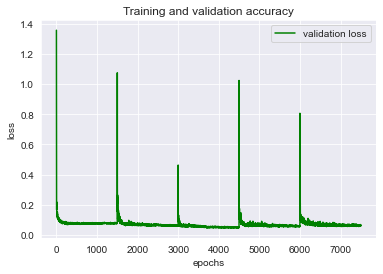

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.clf()
# plt.plot(loss_,'ro',label='training loss')
plt.plot(val_loss_,'g',label='validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
best_loss_

[0.07540051126852632,
 0.07062496244907379,
 0.05440417816862464,
 0.05868933955207467,
 0.0667360806837678]

In [16]:
bl = 0

for i in range(0, 5):
    bl += best_loss_[i]

bl = bl/5

bl

0.06517101442441345